# Price Prediction Models
When we use a pretrained Resnet model and only change the final fully connected layer, the test loss is always at around 1.2 while the train loss is always around 0.5 (See SimpleModel.ipynb). 
We experimented with:
- simple models, like ResNet18 with one fc linear layer
- more complicated ones, like ResNet152 with multiple fc layers
- freezed pretrained models
- fc layers with drop out layers
- optimizers with increased weight decay
- simplified pretrained models by removing a couple of layers

Further, when we train the same model on a dataset with randomly assigned price labels, we get a test loss of about 1.29 and a train loss of also about 1.11. Prices are randomized by shuffling existing price labels, instead of generating random values in a certain range. This is to better represent our dataset and preserve the distribution of prices. Such shuffling allows us to determine whether the original price labels are "random". The results imply that 
- there exists a pattern that can be learned
- the models we trained were not spitting out random values
- so they were indeed learning, but they could not quite grasp the patterns

Judging from these findings, we would need models that are 
- complicated enough to learn the patterns in the determination of art prices
- resistant from overfitting by either
- - being simple, or
- - using weight decay/ dropout/ batch normalization
- "different" from what we had been using, like 
- - from a different pretrained model
- - train a new model instead of using pretrained models
- - with a different approach, like instead of using models designed to detect objects, we may use a model designed to extract style

In [1]:
import torch, torchvision, PIL, numpy as np
import pathlib
import PIL
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import pandas as pd
from tqdm.auto import tqdm
import math
import random
#torch.manual_seed(0)
#np.random.seed(0)
#torch.set_deterministic(True)

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
dataset_dir = "/content/drive/My Drive/CPEN 291/project/data/"

In [4]:
# Modified from object_detection.ipynb
class PricePredictionDataset:
    def __init__(self, root_dir, use_random=False, transform=None, transform_label=None):
        root_dir = pathlib.Path(root_dir).resolve()
        self.root_dir = root_dir
        self.transform = transform
        self.transform_label = transform_label

        if (use_random):
          self.labels_f = pd.read_csv(root_dir / 'all_labels_random.csv')
        else:
          self.labels_f = pd.read_csv(root_dir / 'all_labels.csv')

        def get_price(fn):
            fn = str(fn).rsplit('/', 1)[-1]
            row = self.labels_f.loc[self.labels_f['name'] == fn]
            index = row.index[0]
            return math.log(row['price'][index]) # log because we are scientists

        self.fns_labels = [(imgfn, get_price(imgfn))
                           for imgfn in sorted(root_dir.glob('*.jpg'))]

    def __len__(self):
        return len(self.fns_labels)

    def __getitem__(self, i):
        if torch.is_tensor(i):
            i = i.item()
        imgfn, label = self.fns_labels[i]
        img = PIL.Image.open(imgfn)
        if (len(img.split()) > 3): # some images have one more channel
          r,g,b, _ = img.split()
          img = PIL.Image.merge('RGB', (r,g,b))
        if (len(img.split()) == 1): # some images only have one channel
          img = img.convert('RGB')
        if self.transform:
            img = self.transform(img)
        if self.transform_label:
            label = self.transform_label(label)
        return (img, label)

In [5]:
# Modified from object_detection.ipynb
def show_img_price(sample):
    img, price = sample
    if torch.is_tensor(img):
        img = img.cpu().permute(1,2,0)
    plt.imshow(img)
    plt.title(math.e**price, color='black') # add color='w' arg if using a dark background
    plt.axis('off')

In [6]:
dataset_tmp = PricePredictionDataset(dataset_dir)

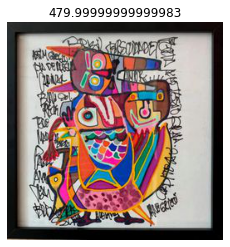

In [7]:
show_img_price(dataset_tmp[78])

In [8]:
# Transform for benchmarking model # NOT USED ANYMORE
def randolabo(anything):
  return random.random() * 3 + 6 # log(20000) ~ 9.9, log(1000) ~ 6.9

4498


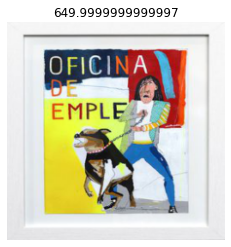

In [9]:
xform = torchvision.transforms.Compose([torchvision.transforms.Resize((224,224)), torchvision.transforms.ToTensor()])
#dataset_full= PricePredictionDataset(dataset_dir, True, transform=xform)
dataset_full= PricePredictionDataset(dataset_dir, False, transform=xform)
print(len(dataset_full))
show_img_price(dataset_full[102])

In [10]:
n_all= len(dataset_full)
n_used= int(1 * n_all)
n_train= int(0.8 * n_used)
n_test= n_used- n_train
rng= torch.Generator().manual_seed(1910)
dataset_train, dataset_test, _ = torch.utils.data.random_split(dataset_full, [n_train, n_test, n_all-n_train-n_test], rng)
len(dataset_train), len(dataset_test)

(3598, 900)

In [11]:
loader_train = torch.utils.data.DataLoader(dataset_train, batch_size=32, shuffle=False)
loader_test = torch.utils.data.DataLoader(dataset_test, batch_size=32, shuffle=False)

In [12]:
pt = False
trim = False
model= torchvision.models.resnet18(pretrained=pt) # complicated models tend to overfit
print(model.fc.in_features) # fc for resnet
#print(model.classifier.in_features) # classifier for densenet
#print(model.classifier[-1].in_features) # classifier[-1] for vgg

#for param in model.parameters():
#  param.requires_grad = False # freeze pretrained layers, otherwise it tends to overfit quickly

# from https://discuss.pytorch.org/t/how-to-delete-layer-in-pretrained-model/17648/2
class Identity(torch.nn.Module):
    def __init__(self):
        super(Identity, self).__init__()
        
    def forward(self, x):
        return x
if (trim):
  model.layer3 = Identity();
  model.layer4 = Identity();

# from https://discuss.pytorch.org/t/reset-model-weights/19180/4
def weights_init(m):
  if isinstance(m, torch.nn.Conv2d):
      torch.nn.init.xavier_uniform_(m.weight.data)

if (not pt):
  model.apply(weights_init)
  for child in model.children():
    child.apply(weights_init)
    for c in child.children():
      c.apply(weights_init)
      for h in c.children():
        h.apply(weights_init)
        for i in h.children():
          i.apply(weights_init)


model.fc = torch.nn.Sequential(
    torch.nn.Linear(model.fc.in_features, 1),
    #torch.nn.Linear(128, 1),

#    torch.nn.ReLU(),
#    torch.nn.Linear(1024, 1024),
#    torch.nn.ReLU(),
#    torch.nn.Linear(1024, 512),
#    torch.nn.ReLU(),
#    torch.nn.Linear(512, 128),
#    torch.nn.ReLU(),
#    torch.nn.Linear(1024, 128),
#    torch.nn.ReLU(),
#    torch.nn.Linear(128, 1)
)
torch.nn.init.xavier_uniform_(model.fc[0].weight)
#torch.nn.init.xavier_uniform_(model.fc[2].weight)
#torch.nn.init.xavier_uniform_(model.classifier[-1][4].weight)
#torch.nn.init.xavier_uniform_(model.classifier[6].weight)
#torch.nn.init.xavier_uniform_(model.classifier[8].weight)
#torch.nn.init.xavier_uniform_(model.classifier[10].weight)


device = torch.device('cuda:0')
model.to(device);


512


In [13]:
criterion = torch.nn.MSELoss()
# For pretrained
#optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=0.1)
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=0.5)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)
# For untrained
if (not pt):
  optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.1) #, weight_decay=0.1)
  #scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.7)
  scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[30, 80], gamma=0.1)

In [14]:
def run_test(model, criterion, no_preds=False):
    nsamples_test = len(dataset_test)
    loss = 0
    preds = []
    model.eval()
    with torch.no_grad():
        for samples, labels in loader_test:
            samples = samples.to(device)
            labels = labels.to(device).float().unsqueeze(1)
            outs = model(samples)
            if not no_preds:
                preds += outs.cpu().unbind()
            loss += criterion(outs, labels) * samples.size(0)
    return loss / nsamples_test, preds

def run_train(model, criterion, opt, sched):
    nsamples_train = len(dataset_train)
    loss_sofar = 0
    model.train()
    with torch.enable_grad():
        for samples, labels in tqdm(loader_train, desc='iters', leave=False):
            samples = samples.to(device)
            labels = labels.to(device).float().unsqueeze(1)
            opt.zero_grad()
            outs = model(samples)
            loss = criterion(outs, labels)
            loss.backward()
            opt.step()
            loss_sofar += loss.item() * samples.size(0)
            if (math.isnan(loss.item())):
              print("loss nan")
              print(loss)
    sched.step()
    return loss_sofar / nsamples_train

def run_all(model, criterion, optimizer, scheduler, n_epochs):
    for epoch in tqdm(range(n_epochs), desc='epochs'):
        loss_train = run_train(model, criterion, optimizer, scheduler)
        loss_test, _ = run_test(model, criterion, no_preds=True)
        tqdm.write(f"epoch {epoch+1}: train loss {loss_train:.4f}, test loss {loss_test:.4f}")
    return loss_test

# Use L1loss to train the model until the loss is low enough to use MSEloss # not used
def marathon(model, criterion0, criterion, optimizer, scheduler, n_epochs):
    crit = criterion0
    for epoch in tqdm(range(n_epochs), desc='epochs'):
        loss_train = run_train(model, crit, optimizer, scheduler)
        loss_test, _ = run_test(model, crit, no_preds=True)
        tqdm.write(f"epoch {epoch+1}: train loss {loss_train:.4f}, test loss {loss_test:.4f}")
        if (loss_train < 0.1 and loss_test < 0.1):
          crit = criterion
    return loss_test


In [15]:
run_all(model, criterion, optimizer, scheduler, 40)

epoch 1: train loss 888.7301, test loss 5.1297


epoch 2: train loss 1.8959, test loss 2.4494


epoch 3: train loss 1.6556, test loss 1.9332


epoch 4: train loss 1.5553, test loss 1.7534


epoch 5: train loss 1.4916, test loss 1.6415


epoch 6: train loss 1.4486, test loss 1.6079


epoch 7: train loss 1.4169, test loss 1.5778


epoch 8: train loss 1.3922, test loss 1.5494


epoch 9: train loss 1.3738, test loss 1.5275


epoch 10: train loss 1.3583, test loss 1.5133


epoch 11: train loss 1.3455, test loss 1.5015


epoch 12: train loss 1.3345, test loss 1.4813


epoch 13: train loss 1.3250, test loss 1.4652


epoch 14: train loss 1.3169, test loss 1.4520


epoch 15: train loss 1.3090, test loss 1.4424


epoch 16: train loss 1.3020, test loss 1.4336


epoch 17: train loss 1.2958, test loss 1.4214


epoch 18: train loss 1.2900, test loss 1.4111


epoch 19: train loss 1.2846, test loss 1.4056


epoch 20: train loss 1.2799, test loss 1.3996


epoch 21: train loss 1.2756, test loss 1.3927


epoch 22: train loss 1.2716, test loss 1.3873


epoch 23: train loss 1.2675, test loss 1.3812


epoch 24: train loss 1.2639, test loss 1.3755


epoch 25: train loss 1.2603, test loss 1.3764


epoch 26: train loss 1.2568, test loss 1.3690


epoch 27: train loss 1.2536, test loss 1.3651


epoch 28: train loss 1.2507, test loss 1.3605


epoch 29: train loss 1.2478, test loss 1.3569


epoch 30: train loss 1.2451, test loss 1.3528


epoch 31: train loss 1.2202, test loss 1.2883


epoch 32: train loss 1.2157, test loss 1.2851


epoch 33: train loss 1.2151, test loss 1.2837


epoch 34: train loss 1.2147, test loss 1.2830


epoch 35: train loss 1.2144, test loss 1.2828


epoch 36: train loss 1.2141, test loss 1.2824


epoch 37: train loss 1.2138, test loss 1.2823


epoch 38: train loss 1.2135, test loss 1.2821


epoch 39: train loss 1.2133, test loss 1.2818


epoch 40: train loss 1.2130, test loss 1.2816



tensor(1.2816, device='cuda:0')

In [ ]:
model

| model | fc | optim | train loss | test loss | train loss w/ random | test loss w/ random
| --- | --- |  --- |  --- | --- | --- | --- |
resnet18 20epoch| 1 linear | SGD, wd = 0.5 | 0.5/0.42 | 1.17/1.18 | 1.11/0.9 | 1.29/1.32




model | layers | criterion | optimizer | scheduler | train loss | test loss
--- | --- | --- | --- | --- |--- | --- 
resnet18 untrained (40 epochs) | fc=1 linear | MSELoss | SGD, lr=0.01, m=0.1 | MultiStepLR milestones=30,80, gamma=0.1 | 1.21 | 1.28

In [16]:
torch.save(model.state_dict(), '/content/drive/My Drive/CPEN 291/project/model_jared_1_18_new_40iter.pth')
torch.save(optimizer.state_dict(), '/content/drive/My Drive/CPEN 291/project/optim_jared_1_18_new_40iter.pth')
torch.save(scheduler.state_dict(), '/content/drive/My Drive/CPEN 291/project/sched_jared_1_18_new_40iter.pth')

In [ ]:
test_loss, test_preds= run_test(model, criterion)
print(test_loss)

tensor(1.3219, device='cuda:0')


In [ ]:
test_preds[0]

tensor([8.3090])

Prediction     | Real Price


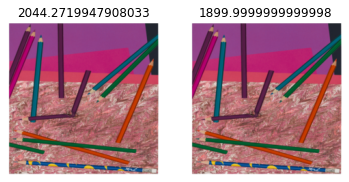

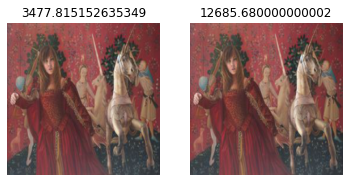

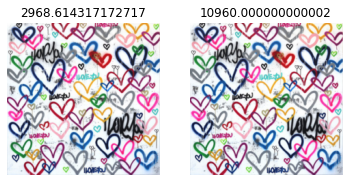

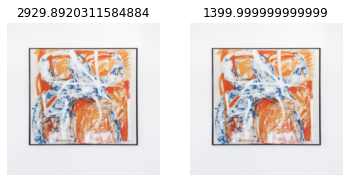

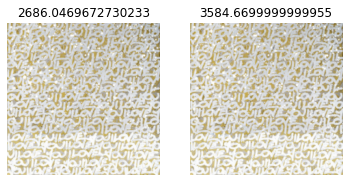

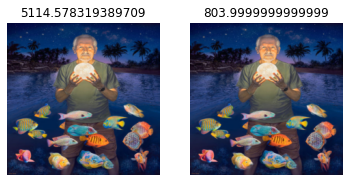

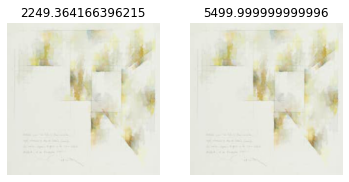

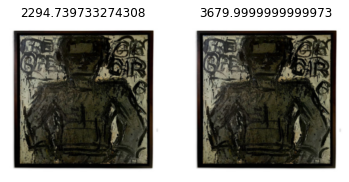

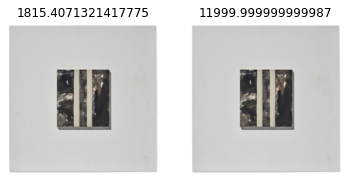

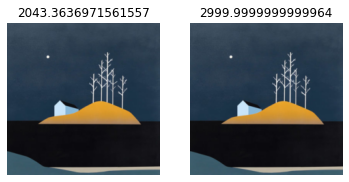

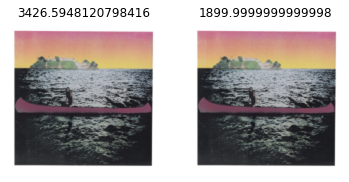

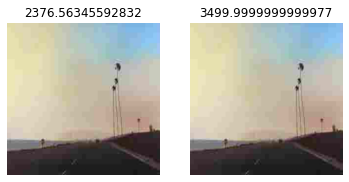

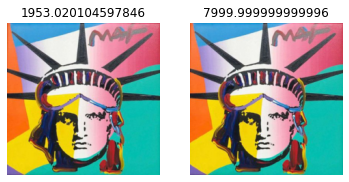

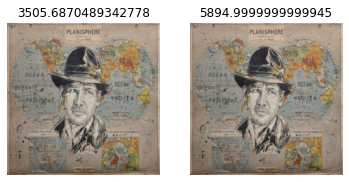

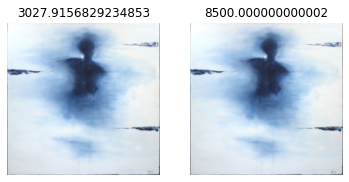

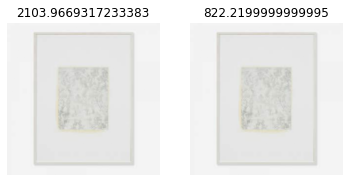

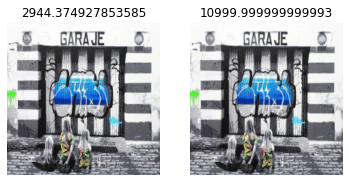

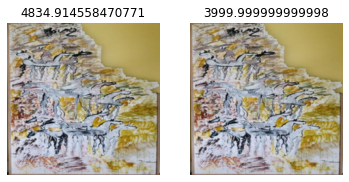

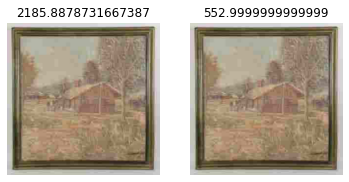

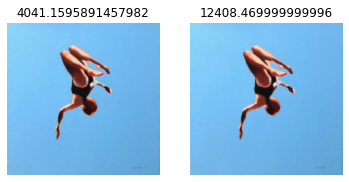

In [ ]:
print("Prediction     | Real Price")
for i in range(20):
    f = plt.figure()
    f.add_subplot(1,2, 1)
    show_img_price((dataset_test[i][0], test_preds[i].item()))
    f.add_subplot(1,2, 2)
    show_img_price(dataset_test[i])
    plt.show(block=True)
